Data

In [1142]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import re

In [1143]:
# ------------------------------------------------------------------------------
# 0) Import and clean
# ------------------------------------------------------------------------------

# Dataframe
proof_dat = pd.read_csv("data-table.csv")

# Preview
proof_dat

,ProofID,InstitutionID,InstitutionType,Topic,Bytes,HasHumanGrade,M_H,M_A,T_H,T_A,...,Con_1,Con_1_Comments,Con_2,Con_2_Comments,Cor,Cor_Comments,DWYD_1,DWYD_2,Right_1,Right_2
0,1,1,Masters,modular arithmetic,453,0,NaN,1,NaN,Variables,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2,1,Masters,induction,1269,0,NaN,1,NaN,Algebra,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,3,1,Masters,set theory,932,0,NaN,1,NaN,Grammar/syntax,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,4,1,Masters,relations,608,1,1.0,1,Justification,Grammar/syntax,...,No they say different things,NaN,No they say different things,Human focused on a specific error. AI focused...,Correct/mostly correct,NaN,0,0,0,0
4,5,1,Masters,modular arithmetic,424,1,0.0,0,No mistakes,No mistakes,...,Yes they say the same thing,NaN,Yes they say the same thing,STYLE,Correct/mostly correct,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,780,5,Masters,induction,483,0,NaN,1,NaN,Structure,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
777,781,5,Masters,induction,316,0,NaN,1,NaN,Argument,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
778,782,5,Masters,induction,662,0,NaN,1,NaN,Algebra,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
779,783,5,Masters,induction,439,0,NaN,1,NaN,Justification,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [1144]:
# Mark categorical columns as such
proof_dat["InstitutionType"] = proof_dat["InstitutionType"].astype("category")
proof_dat["Topic"] = proof_dat["Topic"].astype("category")
proof_dat["T_H"]   = proof_dat["T_H"].astype("category")
proof_dat["T_A"]   = proof_dat["T_A"].astype("category")
proof_dat["Con_1"] = proof_dat["Con_1"].astype("category")
proof_dat["Con_2"] = proof_dat["Con_2"].astype("category")
proof_dat["Cor"] = pd.Categorical(
    proof_dat["Cor"],
    categories=["Wrong/mostly wrong", "Partly correct", "Correct/mostly correct"],
    ordered=True
)

# Mark boolean columns as such
proof_dat["M_H"]     = proof_dat["M_H"].astype("boolean") # nullable boolean for nongraded proofs
proof_dat["HasHumanGrade"]  = proof_dat["HasHumanGrade"].astype(bool)
proof_dat["M_A"]     = proof_dat["M_A"].astype(bool)
proof_dat["DWYD_1"]  = proof_dat["DWYD_1"].astype(bool)
proof_dat["Right_1"] = proof_dat["Right_1"].astype(bool)
proof_dat["DWYD_2"]  = proof_dat["DWYD_2"].astype(bool)
proof_dat["Right_2"] = proof_dat["Right_2"].astype(bool)

# View results
proof_dat

,ProofID,InstitutionID,InstitutionType,Topic,Bytes,HasHumanGrade,M_H,M_A,T_H,T_A,...,Con_1,Con_1_Comments,Con_2,Con_2_Comments,Cor,Cor_Comments,DWYD_1,DWYD_2,Right_1,Right_2
0,1,1,Masters,modular arithmetic,453,False,<NA>,True,NaN,Variables,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
1,2,1,Masters,induction,1269,False,<NA>,True,NaN,Algebra,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2,3,1,Masters,set theory,932,False,<NA>,True,NaN,Grammar/syntax,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
3,4,1,Masters,relations,608,True,True,True,Justification,Grammar/syntax,...,No they say different things,NaN,No they say different things,Human focused on a specific error. AI focused...,Correct/mostly correct,NaN,False,False,False,False
4,5,1,Masters,modular arithmetic,424,True,False,False,No mistakes,No mistakes,...,Yes they say the same thing,NaN,Yes they say the same thing,STYLE,Correct/mostly correct,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,780,5,Masters,induction,483,False,<NA>,True,NaN,Structure,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
777,781,5,Masters,induction,316,False,<NA>,True,NaN,Argument,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
778,782,5,Masters,induction,662,False,<NA>,True,NaN,Algebra,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
779,783,5,Masters,induction,439,False,<NA>,True,NaN,Justification,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False


Hypothesis Testing. The function below was used to produce the hypothesis tests in the paper.

In [1145]:
# ------------------------------------------------------------------------------
# Hypothesis Testing
# ------------------------------------------------------------------------------

# The following function does a hypothesis test for whether population proportion 1 <=
# population proportion 2, and gives an eight-line report of the essential facts.

# The first two arguments can be any pandas Series of boolean values, which will be
# treated as samples, and the sample sizes and proportions computed from those.
# We use the below function to conduct each one of the hypothesis tests to follow.

def hyp_test_pop1_leq_pop2 ( bool_series_1, bool_series_2, name1="sample 1", name2="sample 2", alpha=0.01 ):

    # compute sample sizes, subset sizes, proportions, and differences and print for the user
    samp_size_1 = len(bool_series_1)
    samp_size_2 = len(bool_series_2)
    subset_size_1 = bool_series_1.sum()
    subset_size_2 = bool_series_2.sum()
    samp_prop_1 = subset_size_1/samp_size_1
    print( f'p1hat, {name1}: {subset_size_1} / {samp_size_1} ~= {subset_size_1/samp_size_1:.3f}')
    samp_prop_2 = subset_size_2/samp_size_2
    print( f'p2hat, {name2}: {subset_size_2} / {samp_size_2} ~= {subset_size_2/samp_size_2:.3f}')
    diff = samp_prop_1 - samp_prop_2
    print(f'diff in proportions (p1hat - p2hat): {diff:.3f}')

    # confidence interval for differences in proportions
    ci_low, ci_high = confint_proportions_2indep(
        subset_size_1, samp_size_1, subset_size_2, samp_size_2,
        method="wald", compare="diff", alpha=0.05)
    print(f'95% CI for diff: ({ci_low:.3f}, {ci_high:.3f})')
    width = ci_high - ci_low
    print(f'95% CI width: {width:.3f}')
    rel_width = (ci_high - ci_low) / abs(diff)
    print(f'CI width relative to absolute diff: {rel_width:.2f}x the effect size')

    # check for significance of difference
    if ci_low > 0 or ci_high < 0:
        print("CI excludes 0 → significant difference")
    else:
        print("CI includes 0 → difference may not be significant")

    # prepare values needed by stats.norm.cdf() to compute test statistic
    p_bar = (subset_size_1+subset_size_2)/(samp_size_1+samp_size_2)
    std_error = np.sqrt(p_bar*(1-p_bar)*(1/samp_size_1+1/samp_size_2))  # standard error
    test_statistic = (samp_prop_1 - samp_prop_2)/std_error              # test statistic
    p_value = stats.norm.cdf(test_statistic)

    # report results of hypothesis test using the above test statistic
    print( f'stat ~= {test_statistic:.3f}, p ~= {p_value:.3g}, {"Reject" if p_value < alpha else "Fail to reject"}' )

    # double check test result using statsmodels
    check_stat, check_p = proportions_ztest(
        [subset_size_1, subset_size_2],
        [samp_size_1, samp_size_2],
        alternative="smaller"
    )
    assert np.isclose(test_statistic, check_stat)
    assert np.isclose(p_value, check_p)

    # ---- add separator line ----
    print("-" * 50)   # prints ----------------------------------------

**Section 5.1**

**Table 1.** Results of our data gathering efforts from institutions across the United States.

In [1146]:
# ------------------------------------------------------------------------------
# Table 1: Institutional Data
# ------------------------------------------------------------------------------

# US demographics
ipeds_df = pd.read_csv(
    'https://nces.ed.gov/ipeds/datacenter/data/HD2023.zip',
    encoding='latin', compression='zip' )
def simplify_c21_code ( code ):
    if 1 <= code <= 13:
        return 'Two-year'
    if code == 14 or 21 <= code <= 32:
        return 'Four-year'
    if 18 <= code <= 20:
        return 'Masters'
    if 15 <= code <= 17:
        return 'Doctoral'
    if code == 33:
        return 'Tribal'
    return 'Other'
ipeds_df['C21BASIC_SIMP'] = ipeds_df['C21BASIC'].apply(simplify_c21_code)
us = ipeds_df['C21BASIC_SIMP'].value_counts()
us = pd.DataFrame( {
    "InstitutionType": us.index,
    "Number_in_US": us.values
}, index=range(len(us)) )
us = us[us.InstitutionType != 'Other']
us

,InstitutionType,Number_in_US
1,Four-year,1434
2,Two-year,1266
3,Masters,658
4,Doctoral,465
5,Tribal,35


In [1147]:
# Schools contacted, numbers here from our actual email outreach efforts
contact = pd.DataFrame({
    "InstitutionType": ["Two-year", "Four-year", "Masters", "Doctoral", "Tribal"],
    "Number_contacted": [12, 12, 21, 35, 7]
})
contact

,InstitutionType,Number_contacted
0,Two-year,12
1,Four-year,12
2,Masters,21
3,Doctoral,35
4,Tribal,7


In [1148]:
# Compute number of contributions from each type of institution, using our proofs data file
contrib = (
    proof_dat.groupby(
        "InstitutionType",
        as_index=False,
        observed=False # keep unobserved categories
    ).agg(
        Number_contributing=("InstitutionID", "nunique")
    )
)
contrib

,InstitutionType,Number_contributing
0,Doctoral,1
1,Four-year,1
2,Masters,3


In [1149]:
# Merge dataframes
m = pd.merge(us, contact, on="InstitutionType", how="outer")
m = pd.merge(m, contrib, on="InstitutionType", how="outer")
m = m.sort_values("InstitutionType").reset_index(drop=True)

# Set order
m["InstitutionType"] = pd.Categorical(
    m["InstitutionType"],
    categories=["Two-year", "Four-year", "Masters", "Doctoral", "Tribal"],
    ordered=True
)
m = m.sort_values("InstitutionType").reset_index(drop=True)

# Add zeros for unobserved institution types
m['Number_contributing'] = m['Number_contributing'].fillna(0).astype(int)

# View results
m

,InstitutionType,Number_in_US,Number_contacted,Number_contributing
0,Two-year,1266,12,0
1,Four-year,1434,12,1
2,Masters,658,21,3
3,Doctoral,465,35,1
4,Tribal,35,7,0


In [1150]:
# Add columns for percentages
m["Pct_US"] = (100 * m["Number_in_US"] / m["Number_in_US"].sum()).map("{:.1f}%".format)
m["Pct_contact"] = (100 * m["Number_contacted"] / m["Number_contacted"].sum()).map("{:.1f}%".format)
m["Pct_contrib"] = (100 * m["Number_contributing"] / m["Number_contributing"].sum()).map("{:.0f}%".format)

# Add "Total" row at bottom
total = pd.DataFrame([{
    "InstitutionType": "Total",
    "Number_in_US": m["Number_in_US"].sum(),
    "Number_contacted": m["Number_contacted"].sum(),
    "Number_contributing": m["Number_contributing"].sum(),
    "Pct_US": "100.0%", "Pct_contact": "100.0%", "Pct_contrib": "100%"
}])

tab_1 = pd.concat([m, total], axis=0, ignore_index=True)

# reorder columns
tab_1 = tab_1[[
    "InstitutionType","Number_in_US","Pct_US",
    "Number_contacted","Pct_contact",
    "Number_contributing","Pct_contrib"
]]

# rename columns
tab_1 = tab_1.rename(columns={
    "InstitutionType": "Institution type",
    "Number_in_US": "Number in U.S.",
    "Pct_US": "Percent of Total",
    "Number_contacted": "Number contacted",
    "Pct_contact": "Percent of Total",
    "Number_contributing": "Number contributing",
    "Pct_contrib": "Percent of Total"
})
tab_1

,Institution type,Number in U.S.,Percent of Total,Number contacted,Percent of Total,Number contributing,Percent of Total
0,Two-year,1266,32.8%,12,13.8%,0,0%
1,Four-year,1434,37.2%,12,13.8%,1,20%
2,Masters,658,17.1%,21,24.1%,3,60%
3,Doctoral,465,12.1%,35,40.2%,1,20%
4,Tribal,35,0.9%,7,8.0%,0,0%
5,Total,3858,100.0%,87,100.0%,5,100%


In [1151]:
print(tab_1.to_latex(index=False))

\begin{tabular}{lrlrlrl}
\toprule
Institution type & Number in U.S. & Percent of Total & Number contacted & Percent of Total & Number contributing & Percent of Total \\
\midrule
Two-year & 1266 & 32.8% & 12 & 13.8% & 0 & 0% \\
Four-year & 1434 & 37.2% & 12 & 13.8% & 1 & 20% \\
Masters & 658 & 17.1% & 21 & 24.1% & 3 & 60% \\
Doctoral & 465 & 12.1% & 35 & 40.2% & 1 & 20% \\
Tribal & 35 & 0.9% & 7 & 8.0% & 0 & 0% \\
Total & 3858 & 100.0% & 87 & 100.0% & 5 & 100% \\
\bottomrule
\end{tabular}



**Section 5.3**

**Table 2.** Each student proof was classified into one topic from the list below.

In [1152]:
# ------------------------------------------------------------------------------
# Table 2: Mathematical topics
# ------------------------------------------------------------------------------

# Topics
descriptions = {
    "linear algebra": "matrices, vectors, determinants, vector spaces, spans, null spaces, etc",
    "modular arithmetic": "modular arithmetic and divisibility, grouped because proofs involving one of these topics often involve the other",
    "set theory": "statements whose primary operators are set equality, subset, intersection, etc., even if the defining properties of the sets falls into another topic (e.g., rational numbers)",
    "induction": "proofs by mathematical induction, even if the statement to be proven falls into one of the other topics (e.g., divisibility)",
    "real numbers": "proofs that rely on properties or axioms of the real numbers, such as the Archimedian property, algebraic rules, or decimal expansions",
    "combinatorics": "identities about factorials, combinations, and permutations",
    "gcd": "equalities or inequalities primarily involving the gcd function",
    "relations": "statements about relations, such as whether they are reflexive, symmetric, transitive, linear, total, etc.",
    "functions": "function properties such as injective, surjective, or total",
    "rational numbers": "statements that are primarily about rational numbers and/or proofs that rely on the definition of rational numbers",
    "Gaussian integers": "statements about ordered pairs of integers",
    "Total": ""
}

# Proof count per topic
topics_dat = (
    proof_dat
    .groupby("Topic",observed=True)                     # by topic
    .agg(
        **{
            "No. proofs": ("ProofID", "count"),
            "No. graded": ("HasHumanGrade", "sum")
        }
    )
    .reset_index()                                       # convert to df
    .sort_values("No. proofs", ascending=False)          # sort
    .reset_index(drop=True)                              # fix index (optional)
)

topics_dat

,Topic,No. proofs,No. graded
0,linear algebra,344,100
1,modular arithmetic,190,42
2,set theory,77,25
3,induction,69,19
4,real numbers,41,12
5,combinatorics,17,6
6,gcd,17,1
7,relations,11,3
8,functions,9,4
9,rational numbers,4,0


In [1153]:
# Add a totals row to the above table
totals_row = pd.DataFrame({
    "Topic": ["Total"],
    "No. proofs": [topics_dat["No. proofs"].sum()],
    "No. graded": [topics_dat["No. graded"].sum()]
})
topics_dat = pd.concat([topics_dat, totals_row], axis=0)

# Add descriptions column
topics_dat["Description"] = topics_dat["Topic"].map(descriptions)
tab_2 = topics_dat[["Topic", "No. proofs", "No. graded","Description"]]
tab_2

,Topic,No. proofs,No. graded,Description
0,linear algebra,344,100,"matrices, vectors, determinants, vector spaces..."
1,modular arithmetic,190,42,"modular arithmetic and divisibility, grouped b..."
2,set theory,77,25,statements whose primary operators are set equ...
3,induction,69,19,"proofs by mathematical induction, even if the ..."
4,real numbers,41,12,proofs that rely on properties or axioms of th...
5,combinatorics,17,6,"identities about factorials, combinations, and..."
6,gcd,17,1,equalities or inequalities primarily involving...
7,relations,11,3,"statements about relations, such as whether th..."
8,functions,9,4,"function properties such as injective, surject..."
9,rational numbers,4,0,statements that are primarily about rational n...


In [1154]:
print(tab_2.to_latex(index=False))

\begin{tabular}{lrrl}
\toprule
Topic & No. proofs & No. graded & Description \\
\midrule
linear algebra & 344 & 100 & matrices, vectors, determinants, vector spaces, spans, null spaces, etc \\
modular arithmetic & 190 & 42 & modular arithmetic and divisibility, grouped because proofs involving one of these topics often involve the other \\
set theory & 77 & 25 & statements whose primary operators are set equality, subset, intersection, etc., even if the defining properties of the sets falls into another topic (e.g., rational numbers) \\
induction & 69 & 19 & proofs by mathematical induction, even if the statement to be proven falls into one of the other topics (e.g., divisibility) \\
real numbers & 41 & 12 & proofs that rely on properties or axioms of the real numbers, such as the Archimedian property, algebraic rules, or decimal expansions \\
combinatorics & 17 & 6 & identities about factorials, combinations, and permutations \\
gcd & 17 & 1 & equalities or inequalities primarily invo

**Section 5.6**

**Figure 3.** The units on both axes are “sentence number,” beginning at sentence 1. The only proofs included were identified as containing errors by both human and AI graders. The dashed red line is the y = x line.

Pearson r = 0.451, pval = 4.47e-08


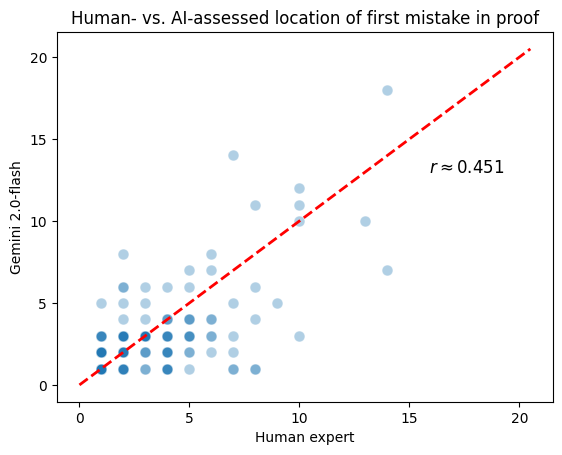

In [1155]:
# ------------------------------------------------------------------------------
# Figure 3: Human vs. AI-assessed location of first mistake in proof
# ------------------------------------------------------------------------------

# we will operate on a copy of the dataframe to compute the Pearson correlation
tmp_cor = proof_dat.copy()

# convert -1 (for no mistake location) → NaN and create floats
for sent_col in ["S_H", "S_A"]:
   tmp_cor.loc[tmp_cor[sent_col] == -1, sent_col] = np.nan
   tmp_cor[sent_col] = tmp_cor[sent_col].astype(float)

# identify all proofs where both human and AI marked a mistake (excludes no mistake and NAs if human did not grade)
mistake = (tmp_cor["M_H"].eq(1)) & (tmp_cor["M_A"].eq(1))
mistake = mistake & tmp_cor["S_H"].notna() & tmp_cor["S_A"].notna()

# get sentences indices of all proofs where both human and AI marked a mistake
human_sent_indices_cor = tmp_cor.loc[mistake,"S_H"]
ai_sent_indices_cor = tmp_cor.loc[mistake,"S_A"]

# find sentence index correlations
pearson=stats.pearsonr(human_sent_indices_cor,ai_sent_indices_cor)
r,pval= stats.pearsonr(human_sent_indices_cor,ai_sent_indices_cor)
print(f"Pearson r = {r:.3f}, pval = {pval:.3g}")

# we will operate on a new copy of the dataframe to make the plot
tmp_plot = proof_dat.copy()

# exclude an outlier for the plot
tmp_plot = tmp_plot.loc[tmp_plot["S_H"] != 29]

# get sentences indices of all proofs where both human and AI marked a mistake (exclude no mistake and NAs if human did not grade)
human_sent_indices_plot= tmp_plot.loc[tmp_plot["M_H"].eq(1) & tmp_plot["M_A"].eq(1),"S_H"]
ai_sent_indices_plot = tmp_plot.loc[tmp_plot["M_H"].eq(1) & tmp_plot["M_A"].eq(1),"S_A"]

# Make correlation matrix into a data frame
sent_ind_df = pd.DataFrame({
    "Human": human_sent_indices_plot,
    "AI": ai_sent_indices_plot
})

# create scatter plot showing pairs of sentence indices for each proof
sns.scatterplot(data=sent_ind_df, x="Human", y="AI", s=60, alpha=0.35)

# Add identity line (y = x)
lims = [
    min(sent_ind_df["Human"].min(), sent_ind_df["AI"].min())-1,
    max(sent_ind_df["Human"].max(), sent_ind_df["AI"].max()) + 2.5,
]
plt.plot(lims, lims, linestyle="--", color="red", linewidth=2)

# Add correlation coefficient to plot
plt.text(
    0.75, 0.62,
    rf"$\it{{r}} \approx {r:.3f}$",
    transform=plt.gca().transAxes,
    fontsize=12
)

# Add labels and formatting to plot
plt.xlabel("Human expert")
plt.ylabel("Gemini 2.0-flash")
plt.title("Human- vs. AI-assessed location of first mistake in proof")
plt.grid(False)

# save and show plot
plt.savefig( 'sentence-index-scatterplot-gemini-2.0-flash.pdf', bbox_inches='tight' )
plt.show()

**Figure 4.** The headings are abbreviations of the categories from Table 3, plus “No mistakes.” Each cell represents the number of proofs assessed by the human experts and AI in a unique combination of mistake types according to its row and column headings. The red areas show how frequently humans and AI agree a proof contains each mistake type.

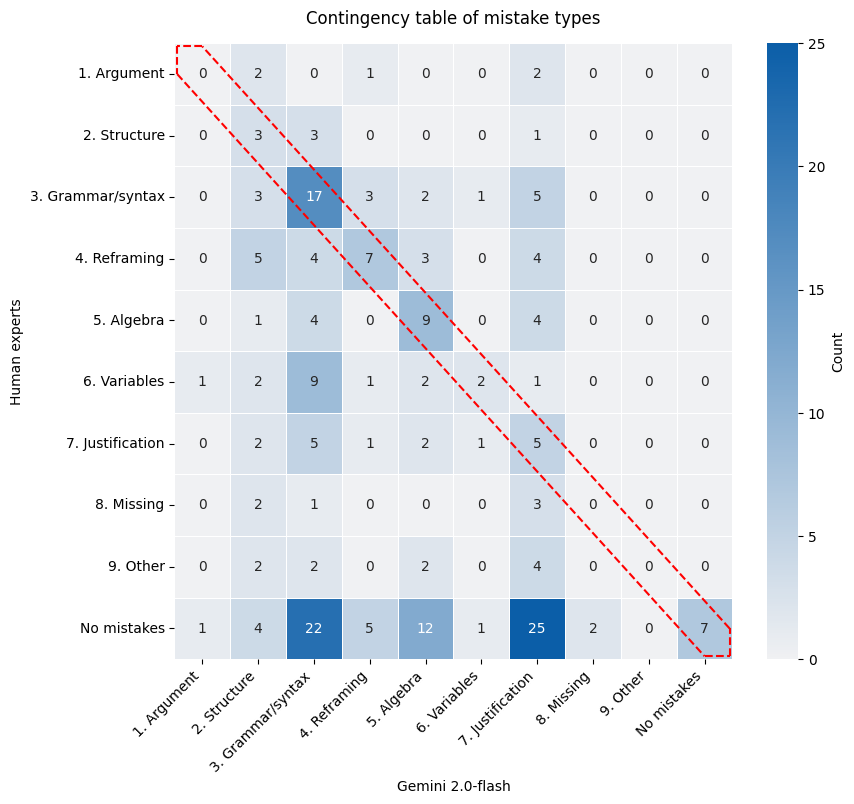

In [1157]:
# ------------------------------------------------------------------------------
# Figure 4: Contingency table of mistake types
# ------------------------------------------------------------------------------

# Create abbreviated names for all mistake types, plus "no mistake" category
mistake_types = [
    "Argument","Structure","Grammar/syntax","Reframing",
    "Algebra","Variables","Justification","Missing","Other","No mistakes"
]

# Create contingency table
conting_table = pd.crosstab(
    pd.Categorical(proof_dat["T_H"], categories=mistake_types, ordered=True),
    pd.Categorical(proof_dat["T_A"], categories=mistake_types, ordered=True)
).reindex(index=mistake_types, columns=mistake_types, fill_value=0)

# Improve the row and column headings of the heatmap
# using mistake numbers from Table 3 of the paper
conting_table.columns = conting_table.index = [
    f"{i}. {mistake_types[i-1]}" for i in range(1, 10)
] + ["No mistakes"]

# set up the plot formatting
plt.figure(figsize=(9, 8))
ax = sns.heatmap(
    conting_table,
    annot=True, fmt="d",
    cmap=sns.light_palette("#0b5ea8", as_cmap=True),
    cbar_kws={"label": "Count"},
    linewidths=.5, linecolor="white"
)

# create title/axes
ax.set_title("Contingency table of mistake types", pad=14)
ax.set_xlabel("Gemini 2.0-flash")
ax.set_ylabel("Human experts")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# add red diagonal box around the diagonal cells
TABLE_SIZE = 10
MARGIN = 0.05
def linebit (x1,y1,x2,y2):
    x1 = min(max(x1,MARGIN),TABLE_SIZE-MARGIN)
    x2 = min(max(x2,MARGIN),TABLE_SIZE-MARGIN)
    y1 = min(max(y1,MARGIN),TABLE_SIZE-MARGIN)
    y2 = min(max(y2,MARGIN),TABLE_SIZE-MARGIN)
    plt.plot( [x1,x2],[y1,y2], color='red', linestyle='--' )
def linebits (*args):
    for i in range(0,len(args),2):
        if i + 4 <= len(args):
            linebit(args[i],args[i+1],args[i+2],args[i+3])
linebits( 0,0, 0,0.5, 9.5,10, 10,10, 10,9.5, 0.5,0, 0,0 )

# save and show the plot
plt.savefig( 'contingency-table-gemini-2.0-flash.pdf', bbox_inches='tight' )
plt.show()

Footnote:  What percentage of assessed proofs were marked as having the AI feedback correct and the human feedback incorrect?

In [1158]:
# Select the subset of the proofs that were graded by both humans and AI
grade_dat = proof_dat[proof_dat["HasHumanGrade"].eq(1)]

In [1159]:
# Embedded use case
euc_human_errors = grade_dat['Right_1'].value_counts()
euc_human_errors

,count
Right_1,
False,202
True,11


In [1160]:
euc_human_errors[True] / euc_human_errors.sum()

np.float64(0.051643192488262914)

In [1161]:
# Student use case
suc_human_errors = grade_dat['Right_2'].value_counts()
suc_human_errors

,count
Right_2,
False,194
True,19


In [1162]:
suc_human_errors[True] / suc_human_errors.sum()

np.float64(0.0892018779342723)

**Section 5.7**

In [1163]:
# ------------------------------------------------------------------------------
# Hypothesis Testing 1
# ------------------------------------------------------------------------------

# Is overall human grader mistake-finding rate less than the same for AI in the EUC?
hyp_test_pop1_leq_pop2( grade_dat['M_H'], grade_dat['M_A'],
    name1="human grader mistake-finding rate",
    name2="AI grader mistake-finding rate" )

p1hat, human grader mistake-finding rate: 134 / 213 ~= 0.629
p2hat, AI grader mistake-finding rate: 206 / 213 ~= 0.967
diff in proportions (p1hat - p2hat): -0.338
95% CI for diff: (-0.407, -0.269)
95% CI width: 0.138
CI width relative to absolute diff: 0.41x the effect size
CI excludes 0 → significant difference
stat ~= -8.691, p ~= 1.8e-18, Reject
--------------------------------------------------


**Section 6.1**

In [1164]:
# ------------------------------------------------------------------------------
# Hypothesis Testing 2
# ------------------------------------------------------------------------------

# Is Consistent% less for EUC than SUC?
hyp_test_pop1_leq_pop2(
    grade_dat['Con_1'].str.startswith( 'Yes' ),
    grade_dat['Con_2'].str.startswith( 'Yes' ),
    name1="EUC Consistent%",
    name2="SUC Consistent%"
)

p1hat, EUC Consistent%: 79 / 213 ~= 0.371
p2hat, SUC Consistent%: 112 / 213 ~= 0.526
diff in proportions (p1hat - p2hat): -0.155
95% CI for diff: (-0.248, -0.062)
95% CI width: 0.187
CI width relative to absolute diff: 1.20x the effect size
CI excludes 0 → significant difference
stat ~= -3.215, p ~= 0.000652, Reject
--------------------------------------------------


**Table 6.** Summary of assessments made by human volunteers about the consistency of human-given feedback and AI-given feedback

In [1165]:
# ------------------------------------------------------------------------------
# Table 6: Use Case Consistency Comparisons
# ------------------------------------------------------------------------------

# create a function that creates a table of the frequencies
# (both counts and percentages) of rows categorized by a selected
# categorical column
def counts_and_percents (df, col, newname, order):
    result = (
        df
        .groupby(col, observed=True)
        .size()                            # aggregate by count
        .reset_index(name="Count")         # convert to DataFrame
        .rename(columns={col: newname})
    )
    # add percent column
    total = result["Count"].sum()
    result["Percent"] = (
        100 * result["Count"] / total
    ).map("{:.1f}%".format)
    # add totals row
    result = pd.concat(
        [result, pd.DataFrame(dict([
            [newname, ["Total"]],
            ["Count", [total]],
            ["Percent", ["100.0%"]]
        ]))],
        ignore_index=True
    )
    # set order
    result = result.set_index(newname).reindex(order).reset_index()
    return result

# define consistency constants
con_name = 'Consistency with human expert'
con_order = [
    "Yes they say the same thing",
    "No they say different things",
    "Total"
]

# summarize embedded use case
euc_con = counts_and_percents(grade_dat, "Con_1", con_name, con_order)
euc_con

,Consistency with human expert,Count,Percent
0,Yes they say the same thing,79,37.1%
1,No they say different things,134,62.9%
2,Total,213,100.0%


In [1166]:
# summarize student use case
suc_con = counts_and_percents(grade_dat, "Con_2", con_name, con_order)
suc_con

,Consistency with human expert,Count,Percent
0,Yes they say the same thing,112,52.6%
1,No they say different things,101,47.4%
2,Total,213,100.0%


In [1167]:
# side-by-side merge of the above two cases on the leftmost descriptor column
tab_6 = euc_con.merge(suc_con, on=con_name, how="inner", suffixes=("_Embedded","_Student"))

# MultiIndex headers: (group, subheader)
tab_6.columns = pd.MultiIndex.from_tuples([
    ("", "Consistency with human expert"),
    ("Embedded Use Case", "Count"),
    ("Embedded Use Case", "Percent"),
    ("Student Use Case", "Count"),
    ("Student Use Case", "Percent"),
])

# View results
tab_6

Embedded Use Case         Student Use Case  \
  Consistency with human expert             Count Percent            Count   
0   Yes they say the same thing                79   37.1%              112   
1  No they say different things               134   62.9%              101   
2                         Total               213  100.0%              213   

           
  Percent  
0   52.6%  
1   47.4%  
2  100.0%

In [1168]:
print(tab_6.to_latex(index=False))

\begin{tabular}{lrlrl}
\toprule
 & \multicolumn{2}{r}{Embedded Use Case} & \multicolumn{2}{r}{Student Use Case} \\
Consistency with human expert & Count & Percent & Count & Percent \\
\midrule
Yes they say the same thing & 79 & 37.1% & 112 & 52.6% \\
No they say different things & 134 & 62.9% & 101 & 47.4% \\
Total & 213 & 100.0% & 213 & 100.0% \\
\bottomrule
\end{tabular}



**Table 7.** Summary of assessments made by human volunteers about the correctness of AI-given feedback

In [1169]:
# ------------------------------------------------------------------------------
# Table 7: Student Use Case AI Accuracy
# ------------------------------------------------------------------------------

# Graded subset, focus on student use case
cor_name = 'Correctness of AI feedback'
tab_7 = (
    grade_dat
    .groupby("Cor", observed=True)          # group by correctness level
    .size()                                 # aggregate by count
    .reset_index(name="Count")              # convert to DataFrame
    .rename(columns={"Cor": cor_name})      # rename column
    .sort_values("Count", ascending=False)  # sort by count
)
tab_7

,Correctness of AI feedback,Count
2,Correct/mostly correct,167
1,Partly correct,35
0,Wrong/mostly wrong,11


In [1170]:
# Add percentages column
total_cor = tab_7["Count"].sum()
tab_7["Percent"] = (
    100 * tab_7["Count"] / total_cor
).map("{:.1f}%".format)

# Add totals row
total_row_cor = pd.DataFrame({
    cor_name: ["Total"],
    "Count": [total_cor],
    "Percent": ["100.0%"]
})
tab_7 = pd.concat(
    [tab_7, total_row_cor],
    axis=0,
    ignore_index=True,
    join="outer"
)

# Use multi-index for header to specify use case
tab_7.columns = pd.MultiIndex.from_tuples([
    ("", cor_name),
    ("Student Use Case", "Count"),
    ("Student Use Case", "Percent")
])

tab_7

Student Use Case        
  Correctness of AI feedback            Count Percent
0     Correct/mostly correct              167   78.4%
1             Partly correct               35   16.4%
2         Wrong/mostly wrong               11    5.2%
3                      Total              213  100.0%

In [1171]:
print(tab_7.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
 & \multicolumn{2}{r}{Student Use Case} \\
Correctness of AI feedback & Count & Percent \\
\midrule
Correct/mostly correct & 167 & 78.4% \\
Partly correct & 35 & 16.4% \\
Wrong/mostly wrong & 11 & 5.2% \\
Total & 213 & 100.0% \\
\bottomrule
\end{tabular}



**Section 6.2.1**

**Table 8.** Summary of assessments made by human volunteers about the consistency of human-given feedback and AI-given feedback, broken down by mathematical topic of the proof being graded. Only the three most common mathematical topics are included here.



In [1172]:
# ------------------------------------------------------------------------------
# Table 8: Use Case Consistency Comparisons by Common Topics
# ------------------------------------------------------------------------------

# we will build a table with three different topics in it
topics = ["linear algebra", "modular arithmetic", "set theory"]

# we use this loop to create an array of the table parts,
# then concatenate them together below
blocks = []
for topic in topics:
    # select rows for the topic in question
    sub = grade_dat.loc[grade_dat["Topic"] == topic]

    # summarize consistency for each use case
    # (uses a function defined above for Table 7)
    euc_con = counts_and_percents(sub, "Con_1", con_name, con_order)
    suc_con = counts_and_percents(sub, "Con_2", con_name, con_order)

    # side-by-side merge on the leftmost descriptor column
    merged = euc_con.merge(suc_con, on=con_name, how="inner",
        suffixes=("_Embedded","_Student"))

    # MultiIndex headers: (group, subheader)
    merged.columns = pd.MultiIndex.from_tuples([
        ("", "Consistency with human expert"),
        ("Embedded Use Case", "Count"),
        ("Embedded Use Case", "Percent"),
        ("Student Use Case", "Count"),
        ("Student Use Case", "Percent"),
    ])

    # insert a single-row topic header
    header_row = pd.DataFrame(
        [[f"Topic: {topic}", "", "", "", ""]],
        columns=merged.columns
    )

    # add the work we just did to the blocks list
    blocks.append(header_row)
    blocks.append(merged)

# concatenate all topic sections into the final table
tab_8 = pd.concat(blocks, ignore_index=True)
tab_8

Embedded Use Case         Student Use Case  \
   Consistency with human expert             Count Percent            Count   
0          Topic: linear algebra                                              
1    Yes they say the same thing                27   27.0%               41   
2   No they say different things                73   73.0%               59   
3                          Total               100  100.0%              100   
4      Topic: modular arithmetic                                              
5    Yes they say the same thing                22   52.4%               28   
6   No they say different things                20   47.6%               14   
7                          Total                42  100.0%               42   
8              Topic: set theory                                              
9    Yes they say the same thing                13   52.0%               19   
10  No they say different things                12   48.0%                6   
11                         Total                25  100.0%               25   

            
   Percent  
0           
1    41.0%  
2    59.0%  
3   100.0%  
4           
5    66.7%  
6    33.3%  
7   100.0%  
8           
9    76.0%  
10   24.0%  
11  100.0%

In [1173]:
print(tab_8.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{Embedded Use Case} & \multicolumn{2}{r}{Student Use Case} \\
Consistency with human expert & Count & Percent & Count & Percent \\
\midrule
Topic: linear algebra &  &  &  &  \\
Yes they say the same thing & 27 & 27.0% & 41 & 41.0% \\
No they say different things & 73 & 73.0% & 59 & 59.0% \\
Total & 100 & 100.0% & 100 & 100.0% \\
Topic: modular arithmetic &  &  &  &  \\
Yes they say the same thing & 22 & 52.4% & 28 & 66.7% \\
No they say different things & 20 & 47.6% & 14 & 33.3% \\
Total & 42 & 100.0% & 42 & 100.0% \\
Topic: set theory &  &  &  &  \\
Yes they say the same thing & 13 & 52.0% & 19 & 76.0% \\
No they say different things & 12 & 48.0% & 6 & 24.0% \\
Total & 25 & 100.0% & 25 & 100.0% \\
\bottomrule
\end{tabular}



In [1174]:
# ------------------------------------------------------------------------------
# Hypothesis Testing 3
# ------------------------------------------------------------------------------

# Is EUC linear algebra Consistent% <= same for modular arithmetic?
hyp_test_pop1_leq_pop2(
    grade_dat[grade_dat['Topic']=='linear algebra']['Con_1'].str.startswith( 'Yes' ),
    grade_dat[grade_dat['Topic']=='modular arithmetic']['Con_1'].str.startswith( 'Yes' ),
    name1="EUC linear algebra Consistent%",
    name2="EUC modular arithmetic Consistent%"
)

# Is EUC linear algebra Consistent% <= same for set theory?
hyp_test_pop1_leq_pop2(
    grade_dat[grade_dat['Topic']=='linear algebra']['Con_1'].str.startswith( 'Yes' ),
    grade_dat[grade_dat['Topic']=='set theory']['Con_1'].str.startswith( 'Yes' ),
    name1="EUC linear algebra Consistent%",
    name2="EUC set theory Consistent%"
)

# Is SUC linear algebra Consistent% <= same for modular arithmetic?
hyp_test_pop1_leq_pop2(
    grade_dat[grade_dat['Topic']=='linear algebra']['Con_2'].str.startswith( 'Yes' ),
    grade_dat[grade_dat['Topic']=='modular arithmetic']['Con_2'].str.startswith( 'Yes' ),
    name1="SUC linear algebra Consistent%",
    name2="SUC modular arithmetic Consistent%"
)

# Is SUC linear algebra Consistent% <= same for set theory?
hyp_test_pop1_leq_pop2(
    grade_dat[grade_dat['Topic']=='linear algebra']['Con_2'].str.startswith( 'Yes' ),
    grade_dat[grade_dat['Topic']=='set theory']['Con_2'].str.startswith( 'Yes' ),
    name1="SUC linear algebra Consistent%",
    name2="SUC set theory Consistent%"
)

p1hat, EUC linear algebra Consistent%: 27 / 100 ~= 0.270
p2hat, EUC modular arithmetic Consistent%: 22 / 42 ~= 0.524
diff in proportions (p1hat - p2hat): -0.254
95% CI for diff: (-0.428, -0.079)
95% CI width: 0.349
CI width relative to absolute diff: 1.37x the effect size
CI excludes 0 → significant difference
stat ~= -2.904, p ~= 0.00184, Reject
--------------------------------------------------
p1hat, EUC linear algebra Consistent%: 27 / 100 ~= 0.270
p2hat, EUC set theory Consistent%: 13 / 25 ~= 0.520
diff in proportions (p1hat - p2hat): -0.250
95% CI for diff: (-0.464, -0.036)
95% CI width: 0.429
CI width relative to absolute diff: 1.71x the effect size
CI excludes 0 → significant difference
stat ~= -2.397, p ~= 0.00827, Reject
--------------------------------------------------
p1hat, SUC linear algebra Consistent%: 41 / 100 ~= 0.410
p2hat, SUC modular arithmetic Consistent%: 28 / 42 ~= 0.667
diff in proportions (p1hat - p2hat): -0.257
95% CI for diff: (-0.429, -0.085)
95% CI width:

**Table 9.** Summary of assessments made by human volunteers about the correctness of AI-given feedback, broken down by mathematical topic of the proof being graded. Only the three most common mathematical topics are included here.

In [1175]:
# ------------------------------------------------------------------------------
# Table 9: Student Use Case AI Accuracy by Common Topics
# ------------------------------------------------------------------------------

# we will build a table with three different topics in it
topics = ["linear algebra", "modular arithmetic", "set theory"]

# each topic will be sorted internally by the following ordering
cor_order = [
    "Correct/mostly correct",
    "Partly correct",
    "Wrong/mostly wrong",
    "Total"
]

# we use this loop to create an array of the table parts,
# then concatenate them together below
blocks = []
for topic in topics:
    # select rows for the topic in question
    sub = grade_dat.loc[grade_dat["Topic"] == topic]

    # summarize consistency for each use case
    # (uses a function defined above for Table 7)
    c = counts_and_percents(sub, "Cor", cor_name, cor_order)

    # replace missing with zeros
    c["Count"] = c["Count"].fillna(0).astype(int)
    c["Percent"] = c["Percent"].fillna("0.0%")

    # add multi-index headers
    c.columns = pd.MultiIndex.from_tuples([
        ("", "Correctness of AI feedback"),
        ("Student Use Case", "Count"),
        ("Student Use Case", "Percent"),
    ])

    # insert a single-row topic header
    header_row = pd.DataFrame(
        [[f"Topic: {topic}", "", ""]],
        columns=c.columns
    )

    # add the work we just did to the blocks list
    blocks.append(header_row)
    blocks.append(c)

# concatenate all topic sections into the final table
tab_9 = pd.concat(blocks, ignore_index=True)
tab_9

Student Use Case        
   Correctness of AI feedback            Count Percent
0       Topic: linear algebra                         
1      Correct/mostly correct               79   79.0%
2              Partly correct               16   16.0%
3          Wrong/mostly wrong                5    5.0%
4                       Total              100  100.0%
5   Topic: modular arithmetic                         
6      Correct/mostly correct               35   83.3%
7              Partly correct                4    9.5%
8          Wrong/mostly wrong                3    7.1%
9                       Total               42  100.0%
10          Topic: set theory                         
11     Correct/mostly correct               21   84.0%
12             Partly correct                4   16.0%
13         Wrong/mostly wrong                0    0.0%
14                      Total               25  100.0%

In [1176]:
print(tab_9.to_latex(index=False))

\begin{tabular}{lll}
\toprule
 & \multicolumn{2}{r}{Student Use Case} \\
Correctness of AI feedback & Count & Percent \\
\midrule
Topic: linear algebra &  &  \\
Correct/mostly correct & 79 & 79.0% \\
Partly correct & 16 & 16.0% \\
Wrong/mostly wrong & 5 & 5.0% \\
Total & 100 & 100.0% \\
Topic: modular arithmetic &  &  \\
Correct/mostly correct & 35 & 83.3% \\
Partly correct & 4 & 9.5% \\
Wrong/mostly wrong & 3 & 7.1% \\
Total & 42 & 100.0% \\
Topic: set theory &  &  \\
Correct/mostly correct & 21 & 84.0% \\
Partly correct & 4 & 16.0% \\
Wrong/mostly wrong & 0 & 0.0% \\
Total & 25 & 100.0% \\
\bottomrule
\end{tabular}



**Section 6.2.2**

**Table 10.** Summary of assessments made by human volunteers about the consistency of human-given feedback and AI-given feedback, broken down by type of mistake, as assessed by a human expert. Only the three most common mistake types are included here.

In [1177]:
# ------------------------------------------------------------------------------
# Table 10: Use Case Consistency Comparisons by Common Mistake Types
# -------------------------------------------------------------------------------

# we will build a table with three different mistake types in it
mistake_subset = [ "Grammar/syntax", "Reframing", "No mistakes" ]

# we use this loop to create an array of the table parts,
# then concatenate them together below
blocks = []
for mistake_type in mistake_subset:
    # select rows for the mistake type in question
    # (according to the human grader)
    sub = grade_dat.loc[grade_dat["T_H"] == mistake_type]

    # summarize consistency for each use case
    # (uses a function defined above for Table 7)
    euc_con = counts_and_percents(sub, "Con_1", con_name, con_order)
    suc_con = counts_and_percents(sub, "Con_2", con_name, con_order)

    # side-by-side merge on the leftmost descriptor column
    merged = euc_con.merge(suc_con, on=con_name, how="inner",
        suffixes=("_Embedded","_Student"))

    # Add MultiIndex headers: (group, subheader)
    merged.columns = pd.MultiIndex.from_tuples([
        ("", con_name),
        ("Embedded Use Case", "Count"),
        ("Embedded Use Case", "Percent"),
        ("Student Use Case", "Count"),
        ("Student Use Case", "Percent"),
    ])

    # insert a single-row topic header
    header_row = pd.DataFrame(
        [[f"Mistake type: {mistake_type}", "", "", "", ""]],
        columns=merged.columns
    )

    # add the work we just did to the blocks list
    blocks.append(header_row)
    blocks.append(merged)

# concatenate all topic sections into the final table
tab_10 = pd.concat(blocks, ignore_index=True)
tab_10

Embedded Use Case         Student Use Case  \
   Consistency with human expert             Count Percent            Count   
0   Mistake type: Grammar/syntax                                              
1    Yes they say the same thing                12   38.7%               12   
2   No they say different things                19   61.3%               19   
3                          Total                31  100.0%               31   
4        Mistake type: Reframing                                              
5    Yes they say the same thing                14   60.9%               15   
6   No they say different things                 9   39.1%                8   
7                          Total                23  100.0%               23   
8      Mistake type: No mistakes                                              
9    Yes they say the same thing                14   17.7%               39   
10  No they say different things                65   82.3%               40   
11                         Total                79  100.0%               79   

            
   Percent  
0           
1    38.7%  
2    61.3%  
3   100.0%  
4           
5    65.2%  
6    34.8%  
7   100.0%  
8           
9    49.4%  
10   50.6%  
11  100.0%

In [1178]:
print(tab_10.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{Embedded Use Case} & \multicolumn{2}{r}{Student Use Case} \\
Consistency with human expert & Count & Percent & Count & Percent \\
\midrule
Mistake type: Grammar/syntax &  &  &  &  \\
Yes they say the same thing & 12 & 38.7% & 12 & 38.7% \\
No they say different things & 19 & 61.3% & 19 & 61.3% \\
Total & 31 & 100.0% & 31 & 100.0% \\
Mistake type: Reframing &  &  &  &  \\
Yes they say the same thing & 14 & 60.9% & 15 & 65.2% \\
No they say different things & 9 & 39.1% & 8 & 34.8% \\
Total & 23 & 100.0% & 23 & 100.0% \\
Mistake type: No mistakes &  &  &  &  \\
Yes they say the same thing & 14 & 17.7% & 39 & 49.4% \\
No they say different things & 65 & 82.3% & 40 & 50.6% \\
Total & 79 & 100.0% & 79 & 100.0% \\
\bottomrule
\end{tabular}



**Table 0.** Summary of assessments made by human volunteers about the correctness of AI-given feedback, broken down by type of mistake, as assessed by a human expert. Only the three most common mistake types are included here.

In [1179]:
# ------------------------------------------------------------------------------
# Table 0 (not used in paper): Student Use Case AI Accuracy by Top Mistake Types
# ------------------------------------------------------------------------------

# we will use cor_order again from Table 9:

cor_order = [
    "Correct/mostly correct",
    "Partly correct",
    "Wrong/mostly wrong",
    "Total"
]

# we use this loop to create an array of the table parts,
# then concatenate them together below
blocks = []
for mistake_type in mistake_subset:
    # select rows for the mistake type in question
    sub = grade_dat.loc[grade_dat["T_H"] == mistake_type]

    # summarize consistency for each use case
    # (uses the function defined for Table 7 again)
    c = counts_and_percents(sub, "Cor", cor_name, cor_order)

    # replace missing with zeros
    c["Count"] = c["Count"].fillna(0).astype(int)
    c["Percent"] = c["Percent"].fillna("0.0%")

    # add multi-index headers
    c.columns = pd.MultiIndex.from_tuples([
        ("", "Correctness of AI feedback"),
        ("Student Use Case", "Count"),
        ("Student Use Case", "Percent"),
    ])

    # insert a single-row topic header
    header_row = pd.DataFrame(
        [[f"Mistake Type: {mistake_type}", "", ""]],
        columns=c.columns
    )

    # add the work we just did to the blocks list
    blocks.append(header_row)
    blocks.append(c)

# concatenate all mistake type sections into the final table
tab_0 = pd.concat(blocks, ignore_index=True)
tab_0


Student Use Case        
      Correctness of AI feedback            Count Percent
0   Mistake Type: Grammar/syntax                         
1         Correct/mostly correct               25   80.6%
2                 Partly correct                6   19.4%
3             Wrong/mostly wrong                0    0.0%
4                          Total               31  100.0%
5        Mistake Type: Reframing                         
6         Correct/mostly correct               18   78.3%
7                 Partly correct                4   17.4%
8             Wrong/mostly wrong                1    4.3%
9                          Total               23  100.0%
10     Mistake Type: No mistakes                         
11        Correct/mostly correct               61   77.2%
12                Partly correct               14   17.7%
13            Wrong/mostly wrong                4    5.1%
14                         Total               79  100.0%

In [1180]:
# ------------------------------------------------------------------------------
# Hypothesis Testing 4
# ------------------------------------------------------------------------------

#Is EUC Grammar/syntax mistake Consistent% <= same for reframing?
hyp_test_pop1_leq_pop2(
    grade_dat[grade_dat['T_H']=='Grammar/syntax']['Con_1'].str.startswith( 'Yes' ),
    grade_dat[grade_dat['T_H']=='Reframing']['Con_1'].str.startswith( 'Yes' ),
    name1="EUC Grammar/syntax Consistent%",
    name2="EUC Reframing Consistent%"
)

p1hat, EUC Grammar/syntax Consistent%: 12 / 31 ~= 0.387
p2hat, EUC Reframing Consistent%: 14 / 23 ~= 0.609
diff in proportions (p1hat - p2hat): -0.222
95% CI for diff: (-0.485, 0.041)
95% CI width: 0.526
CI width relative to absolute diff: 2.37x the effect size
CI includes 0 → difference may not be significant
stat ~= -1.612, p ~= 0.0535, Fail to reject
--------------------------------------------------


**Figure 6.** Distribution of mistake types by grader. The category labels on the x axis are abbreviations of the categories from Table 3 (see paper for table).

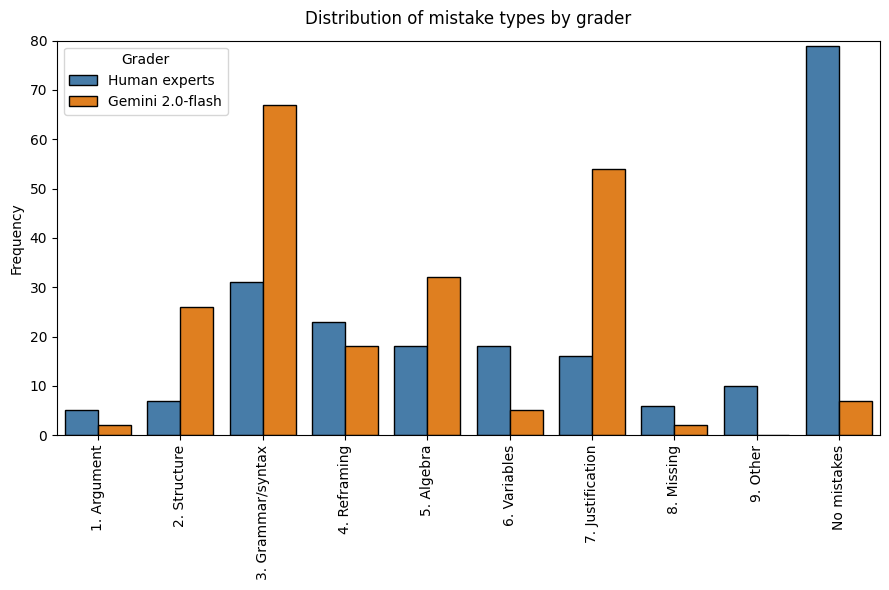

In [1181]:
# ------------------------------------------------------------------------------
# Figure 6: Distribution of mistake types by grader
# ------------------------------------------------------------------------------

# compute bar heights for graph using already-built contingency table
human_counts = conting_table.sum(axis=1).to_numpy()  # row sums
ai_counts    = conting_table.sum(axis=0).to_numpy()  # column sums

# put data in data frame so we can use seaborn more easily below
df = pd.DataFrame({
    "Category":  np.tile(conting_table.columns, 2),
    "Grader":    np.repeat(
        ["Human experts", "Gemini 2.0-flash"],
        repeats=len(mistake_types)
    ),
    "Frequency": np.concatenate([human_counts, ai_counts])
})

# set up plot size and color
fig, ax = plt.subplots(figsize=(9, 6))

# ask seaborn to plot the data
sns.barplot(
    data=df,
    x="Category", y="Frequency", hue="Grader",
    dodge=True, edgecolor="black", ax=ax,
    palette={"Human experts": "#377EB8", "Gemini 2.0-flash": "#FF7F00"}
)

# format axes and titles
ax.set_title("Distribution of mistake types by grader", pad=12)
ax.set_xlabel("")
ax.set_ylabel("Frequency")
ax.set_ylim(0, 80)
ax.set_yticks(np.arange(0, 81, 10))
ax.tick_params(axis="x", rotation=90)
ax.grid(False)

# save and show plot
plt.savefig( 'mistake-type-distribution.pdf', bbox_inches='tight' )
plt.tight_layout()
plt.show()

**Figure 7.** Distributions of proof size, with consistency and inconsistency categories given by the AI responses in the embedded use case.

In [1182]:
# ------------------------------------------------------------------------------
# Figure 7: Distributions of proof size, embedded use case
# ------------------------------------------------------------------------------

# define bins and labels for them
bin_min = 0
bin_max = 2400
num_bins = 12
bin_size = (bin_max - bin_min) / num_bins # this way the bin edges are nice round numbers
breaks = np.round(np.arange(bin_min, bin_min + bin_size*num_bins + 1, bin_size), 0).astype(int)
bin_labs = [f"{a}-{b}" for a, b in zip(breaks[:-1], breaks[1:])]

# How many proofs were excluded?
grade_dat[(grade_dat['Bytes'] < bin_min) | (grade_dat['Bytes'] > bin_max)]

,ProofID,InstitutionID,InstitutionType,Topic,Bytes,HasHumanGrade,M_H,M_A,T_H,T_A,...,Con_1,Con_1_Comments,Con_2,Con_2_Comments,Cor,Cor_Comments,DWYD_1,DWYD_2,Right_1,Right_2
51,52,2,Masters,Gaussian integers,4185,True,True,True,Reframing,Reframing,...,No they say different things,AI criticized sentence 1 but its criticism is ...,No they say different things,AI said what Human said plus more. Some of th...,Partly correct,AI said what Human said plus more. Some of th...,False,False,False,False
492,495,3,Doctoral,linear algebra,2904,True,False,True,No mistakes,Justification,...,No they say different things,DWYD,No they say different things,"STYLE, plus AI wants the student to use concep...",Correct/mostly correct,NaN,True,False,False,False


In [1183]:
# we will operate on a copy of the dataframe
tmp = grade_dat.copy()

# this renaming will make the graph more concise and readable
status_map = {
    "Yes they say the same thing": "Consistent",
    "No they say different things": "Inconsistent",
}
tmp['status'] = tmp["Con_1"].map(status_map)

# add a "bin" column that organizes each proof into bins by length of proof
tmp['bin'] = pd.cut(
    tmp["Bytes"],
    bins=breaks, right=True, include_lowest=True, labels=bin_labs
)

# sort data into bins, but separately for each consistency assessment
tmp = (
    tmp
    .groupby(["status", "bin"], observed=True)   # group by proof length and consistency
    .size()                                      # aggregate by count
    .reset_index(name="count")                   # make clearer name for new column
)
tmp

,status,bin,count
0,Inconsistent,200-400,3
1,Inconsistent,400-600,22
2,Inconsistent,600-800,26
3,Inconsistent,800-1000,33
4,Inconsistent,1000-1200,16
5,Inconsistent,1200-1400,11
6,Inconsistent,1400-1600,10
7,Inconsistent,1600-1800,4
8,Inconsistent,1800-2000,4
9,Inconsistent,2000-2200,1


In [1184]:
# order the bins by size, not alphabetically
tmp["bin"] = pd.Categorical(tmp["bin"], categories=bin_labs, ordered=True)

# compute the percent within each status
tmp["pct"] = (
    tmp
    .groupby("status", observed=True)["count"]
    .transform(lambda s: s / s.sum())
)
tmp

,status,bin,count,pct
0,Inconsistent,200-400,3,0.022727
1,Inconsistent,400-600,22,0.166667
2,Inconsistent,600-800,26,0.196970
3,Inconsistent,800-1000,33,0.250000
4,Inconsistent,1000-1200,16,0.121212
5,Inconsistent,1200-1400,11,0.083333
6,Inconsistent,1400-1600,10,0.075758
7,Inconsistent,1600-1800,4,0.030303
8,Inconsistent,1800-2000,4,0.030303
9,Inconsistent,2000-2200,1,0.007576


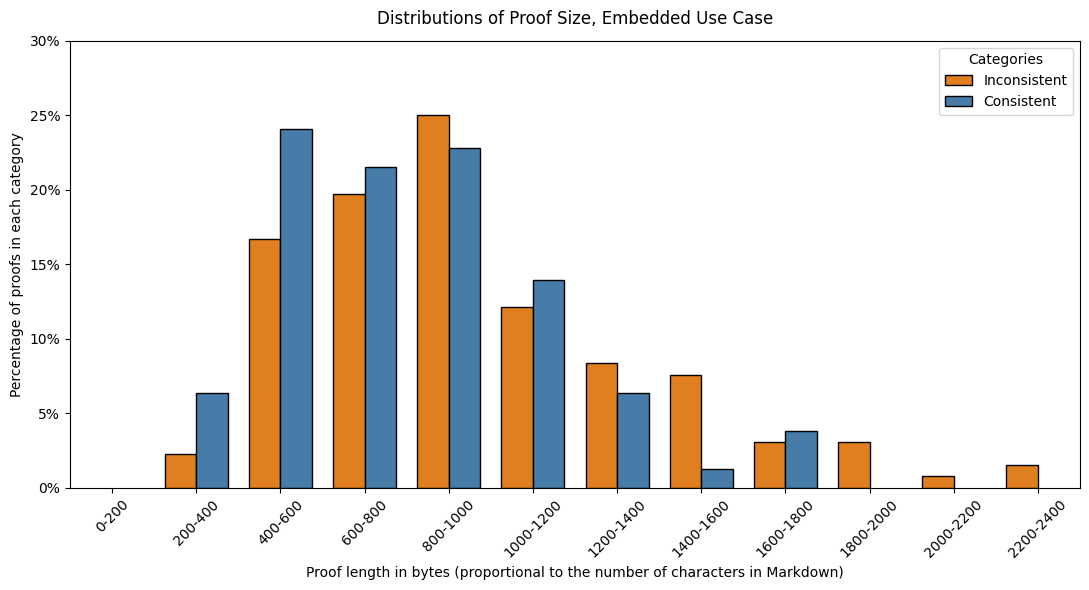

In [1185]:
# ask seaborn to create a plot of these two distributions
fig, ax = plt.subplots(figsize=(11, 6))
sns.barplot(
    data=tmp,
    x="bin", y="pct", hue="status",
    dodge=True, edgecolor="black", width=0.75,
    palette={"Inconsistent": "#FF7F00","Consistent": "#377EB8"},
    ax=ax,
)

# format y axis as a percent, and zoomed comparably to next plot, below
ax.set_ylim(0, 0.3)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# add labels/titles
ax.set_title("Distributions of Proof Size, Embedded Use Case", pad=12)
ax.set_xlabel("Proof length in bytes (proportional to the number of characters in Markdown)")
ax.set_ylabel("Percentage of proofs in each category")

# rotate x axis labels by 45 degrees
ax.tick_params(axis="x", rotation=45)

# don't use the word "status" in the legend
ax.legend(title="Categories", ncol=1, loc="upper right")

# save and show plot
plt.savefig( 'EUC con by size.pdf', bbox_inches='tight' )
plt.tight_layout()
plt.show()

**Figure 8.** The same for the student use case. In each distribution, the percentages (y axis) were computed within each category.

In [1186]:
# ------------------------------------------------------------------------------
# Figure 8: Distributions of proof size, student use case
# ------------------------------------------------------------------------------

# we will operate on a copy of the dataframe
tmp = grade_dat.copy()

# same renaming as in previous plot, for conciseness and readability
tmp['status'] = tmp["Con_2"].map(status_map)

# add a "bin" column that organizes each proof into bins by length of proof
tmp['bin'] = pd.cut(
    tmp["Bytes"],
    bins=breaks, right=True, include_lowest=True, labels=bin_labs
)

# sort data into bins, but separately for each consistency assessment
tmp = (
    tmp
    .groupby(["status", "bin"], observed=True)   # group by proof length and consistency
    .size()                                      # aggregate by count
    .reset_index(name="count")                   # make clearer name for new column
)
tmp

,status,bin,count
0,Inconsistent,200-400,3
1,Inconsistent,400-600,16
2,Inconsistent,600-800,20
3,Inconsistent,800-1000,23
4,Inconsistent,1000-1200,14
5,Inconsistent,1200-1400,10
6,Inconsistent,1400-1600,6
7,Inconsistent,1600-1800,3
8,Inconsistent,1800-2000,2
9,Inconsistent,2000-2200,1


In [1187]:
# order the bins by size, not alphabetically
tmp["bin"] = pd.Categorical(tmp["bin"], categories=bin_labs, ordered=True)

# compute the percent within each status
tmp["pct"] = (
    tmp
    .groupby("status", observed=True)["count"]
    .transform(lambda s: s / s.sum())
)
tmp

,status,bin,count,pct
0,Inconsistent,200-400,3,0.030303
1,Inconsistent,400-600,16,0.161616
2,Inconsistent,600-800,20,0.202020
3,Inconsistent,800-1000,23,0.232323
4,Inconsistent,1000-1200,14,0.141414
5,Inconsistent,1200-1400,10,0.101010
6,Inconsistent,1400-1600,6,0.060606
7,Inconsistent,1600-1800,3,0.030303
8,Inconsistent,1800-2000,2,0.020202
9,Inconsistent,2000-2200,1,0.010101


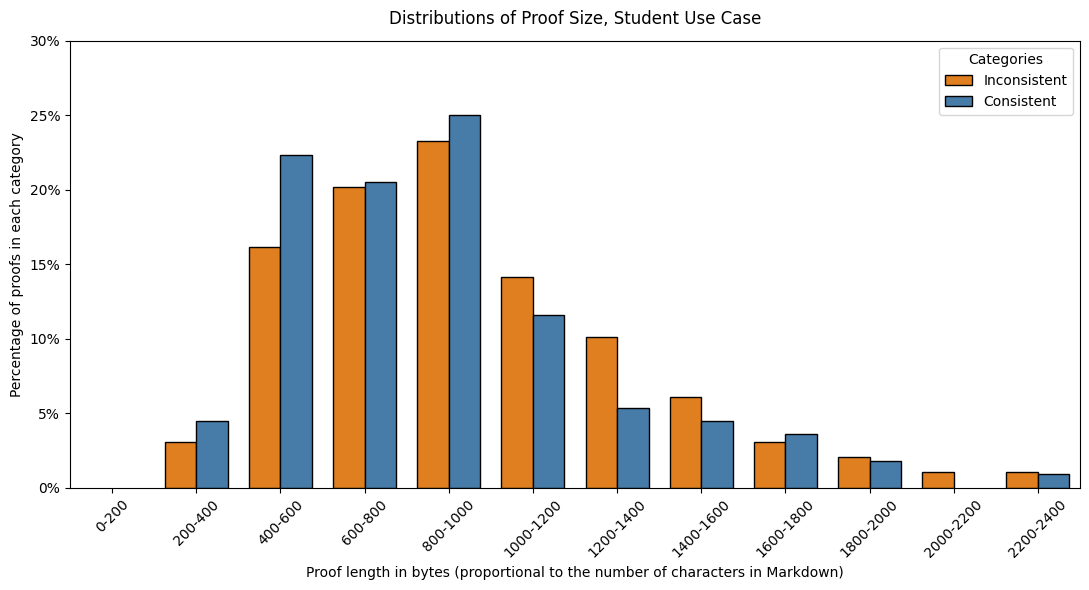

In [1188]:
# ask seaborn to create a plot of these two distributions
fig, ax = plt.subplots(figsize=(11, 6))
sns.barplot(
    data=tmp,
    x="bin", y="pct", hue="status",
    dodge=True, edgecolor="black", width=0.75,
    palette={"Inconsistent": "#FF7F00","Consistent": "#377EB8"},
    ax=ax,
)

# format y axis as a percent, and zoomed comparably to next plot, below
ax.set_ylim(0, 0.3)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# add labels/titles
ax.set_title("Distributions of Proof Size, Student Use Case", pad=12)
ax.set_xlabel("Proof length in bytes (proportional to the number of characters in Markdown)")
ax.set_ylabel("Percentage of proofs in each category")

# rotate x axis labels by 45 degrees
ax.tick_params(axis="x", rotation=45)

# instead of using the word "status" in the legend
ax.legend(title="Categories", ncol=1, loc="upper right")

# save and show plot
plt.savefig( 'SUC con by size.pdf', bbox_inches='tight' )
plt.tight_layout()
plt.show()

In [1189]:
# ------------------------------------------------------------------------------
# Hypothesis Testing 5
# ------------------------------------------------------------------------------

# Is EUC Consistent% <= same for SUC for proofs humans labeled as having no mistake?
hyp_test_pop1_leq_pop2(
    grade_dat[grade_dat['T_H']=='No mistakes']['Con_1'].str.startswith( 'Yes' ),
    grade_dat[grade_dat['T_H']=='No mistakes']['Con_2'].str.startswith( 'Yes' ),
    name1="EUC No mistakes Consistent%",
    name2="SUC No mistakes Consistent%"
)

p1hat, EUC No mistakes Consistent%: 14 / 79 ~= 0.177
p2hat, SUC No mistakes Consistent%: 39 / 79 ~= 0.494
diff in proportions (p1hat - p2hat): -0.316
95% CI for diff: (-0.455, -0.178)
95% CI width: 0.277
CI width relative to absolute diff: 0.88x the effect size
CI excludes 0 → significant difference
stat ~= -4.212, p ~= 1.26e-05, Reject
--------------------------------------------------


**Section 6.3**

Calculation: What percentage of assessed proofs were marked as having the AI feedback instruct the student to "do what you did"?

In [1190]:
# embedded use case
euc_dwyd_feedback = grade_dat['DWYD_1'].value_counts()
euc_dwyd_feedback

,count
DWYD_1,
False,200
True,13


In [1191]:
euc_dwyd_feedback[True] / euc_dwyd_feedback.sum()

np.float64(0.06103286384976526)

In [1192]:
# student use case
suc_dwyd_feedback = grade_dat['DWYD_2'].value_counts()
suc_dwyd_feedback

,count
DWYD_2,
False,198
True,15


In [1193]:
suc_dwyd_feedback[True] / suc_dwyd_feedback.sum()

np.float64(0.07042253521126761)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c255b22f-0373-4b42-8357-9f9654d4fbb8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>